# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:08<00:00, 7.25KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

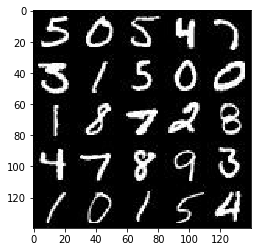

In [1]:
show_n_images = 25
"""
We need run the 1st cell only once to download the data. After which we require only 2 lines from the first cell to continue
with the code execution. Those 2 lines are given below.
"""
import helper
data_dir = './data'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

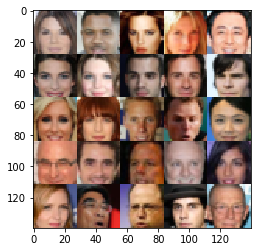

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_images')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name = 'z_data')
    learning_rate = tf.placeholder(tf.float32, (None), name = 'learning_rate')
    return (input_images, z_data, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
    
        l1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha * l1, l1)


        l2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(l2, training = True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        

        l3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(l3, training = True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        #flattening the layer
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse = not is_train):
        l1 = tf.layers.dense(z, 7*7*512)
        
        #Reshaping for convolutional stack
        l1 = tf.reshape(l1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(l1, training = is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)

        l2 = tf.layers.conv2d_transpose(relu1, 64, 5, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(l2, training = is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)

        l3 = tf.layers.conv2d_transpose(relu2, 32, 5, strides = 2, padding = 'same' )
        bn3 = tf.layers.batch_normalization(l3, training = is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        #Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides = 1, padding = 'same')
    
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train = True)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, z_data, lr_var = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, z_data, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr_var, beta1)
    
    saver = tf.train.Saver()
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict = {input_real: batch_images, z_data: batch_z, lr_var: learning_rate})
                _ = sess.run(g_opt, feed_dict = {input_real: batch_images, z_data: batch_z, lr_var: learning_rate})
                
                if(steps % 10 == 0):
                    train_loss_d = d_loss.eval({z_data: batch_z, input_real: batch_images}) 
                    train_loss_g = g_loss.eval({z_data: batch_z})
                
                    print('Epoch {}/{}...'.format(epoch_i+1, epoch_count),
                          'Discriminator Loss: {:.4f}'.format(train_loss_d),
                          'Generator Loss: {:.4f}'.format(train_loss_g))
                
                if(steps % 100 == 0):
                    show_generator_output(sess, 30, z_data, data_shape[3], data_image_mode)
        
        print('Final Output')
        show_generator_output(sess, 30, z_data, data_shape[3], data_image_mode)
        
    return True

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9289 Generator Loss: 16.4423
Epoch 1/2... Discriminator Loss: 0.0547 Generator Loss: 5.4555
Epoch 1/2... Discriminator Loss: 0.8567 Generator Loss: 1.0869
Epoch 1/2... Discriminator Loss: 0.8496 Generator Loss: 1.9332
Epoch 1/2... Discriminator Loss: 0.4398 Generator Loss: 2.1664
Epoch 1/2... Discriminator Loss: 3.2989 Generator Loss: 0.0775
Epoch 1/2... Discriminator Loss: 0.5673 Generator Loss: 1.3551
Epoch 1/2... Discriminator Loss: 0.5161 Generator Loss: 2.1807
Epoch 1/2... Discriminator Loss: 0.6098 Generator Loss: 1.1020
Epoch 1/2... Discriminator Loss: 0.2187 Generator Loss: 2.2165


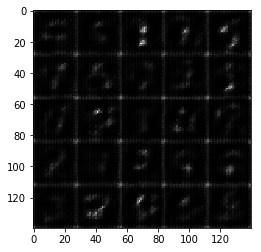

Epoch 1/2... Discriminator Loss: 1.5291 Generator Loss: 0.3687
Epoch 1/2... Discriminator Loss: 0.3609 Generator Loss: 1.7619
Epoch 1/2... Discriminator Loss: 0.1842 Generator Loss: 2.1797
Epoch 1/2... Discriminator Loss: 0.0724 Generator Loss: 3.0836
Epoch 1/2... Discriminator Loss: 0.0136 Generator Loss: 5.6095
Epoch 1/2... Discriminator Loss: 0.4790 Generator Loss: 1.3032
Epoch 1/2... Discriminator Loss: 1.0662 Generator Loss: 1.4802
Epoch 1/2... Discriminator Loss: 0.1722 Generator Loss: 3.0813
Epoch 1/2... Discriminator Loss: 0.4562 Generator Loss: 1.3604
Epoch 1/2... Discriminator Loss: 1.9378 Generator Loss: 0.2521


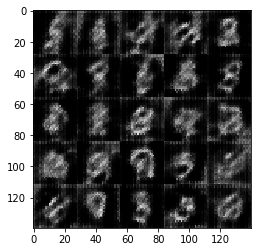

Epoch 1/2... Discriminator Loss: 0.3604 Generator Loss: 1.8902
Epoch 1/2... Discriminator Loss: 0.3903 Generator Loss: 2.1669
Epoch 1/2... Discriminator Loss: 0.0337 Generator Loss: 7.1091
Epoch 1/2... Discriminator Loss: 0.1752 Generator Loss: 2.4425
Epoch 1/2... Discriminator Loss: 0.8862 Generator Loss: 1.1421
Epoch 1/2... Discriminator Loss: 2.1634 Generator Loss: 0.2917
Epoch 1/2... Discriminator Loss: 1.2810 Generator Loss: 1.9184
Epoch 1/2... Discriminator Loss: 0.9614 Generator Loss: 1.2018
Epoch 1/2... Discriminator Loss: 0.4541 Generator Loss: 1.6966
Epoch 1/2... Discriminator Loss: 0.7540 Generator Loss: 0.7806


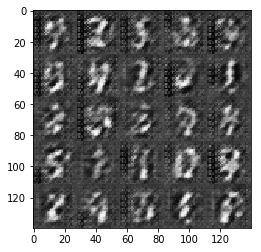

Epoch 1/2... Discriminator Loss: 0.2539 Generator Loss: 3.0265
Epoch 1/2... Discriminator Loss: 0.0764 Generator Loss: 5.2909
Epoch 1/2... Discriminator Loss: 0.4432 Generator Loss: 2.4642
Epoch 1/2... Discriminator Loss: 0.0659 Generator Loss: 4.9778
Epoch 1/2... Discriminator Loss: 1.4500 Generator Loss: 0.5514
Epoch 1/2... Discriminator Loss: 1.3890 Generator Loss: 1.0552
Epoch 1/2... Discriminator Loss: 1.8124 Generator Loss: 0.2215
Epoch 1/2... Discriminator Loss: 0.5608 Generator Loss: 2.1213
Epoch 1/2... Discriminator Loss: 1.3293 Generator Loss: 1.0649
Epoch 1/2... Discriminator Loss: 1.2149 Generator Loss: 0.6012


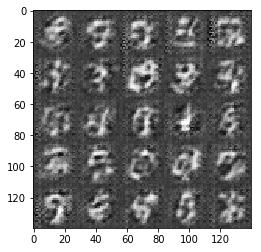

Epoch 1/2... Discriminator Loss: 0.9851 Generator Loss: 0.8725
Epoch 1/2... Discriminator Loss: 0.5053 Generator Loss: 1.1893
Epoch 1/2... Discriminator Loss: 0.8379 Generator Loss: 1.4041
Epoch 1/2... Discriminator Loss: 0.8799 Generator Loss: 1.0707
Epoch 1/2... Discriminator Loss: 1.8002 Generator Loss: 0.2824
Epoch 1/2... Discriminator Loss: 0.4621 Generator Loss: 1.3721
Epoch 1/2... Discriminator Loss: 0.4342 Generator Loss: 1.4827
Epoch 1/2... Discriminator Loss: 0.1478 Generator Loss: 2.6927
Epoch 1/2... Discriminator Loss: 0.3552 Generator Loss: 1.5402
Epoch 1/2... Discriminator Loss: 1.0539 Generator Loss: 0.9400


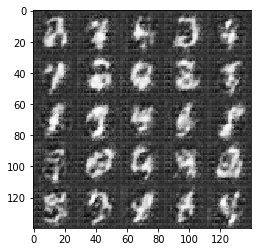

Epoch 1/2... Discriminator Loss: 1.6576 Generator Loss: 0.2533
Epoch 1/2... Discriminator Loss: 0.7477 Generator Loss: 0.8687
Epoch 1/2... Discriminator Loss: 1.3707 Generator Loss: 0.3539
Epoch 1/2... Discriminator Loss: 0.9378 Generator Loss: 0.7343
Epoch 1/2... Discriminator Loss: 0.3889 Generator Loss: 1.4651
Epoch 1/2... Discriminator Loss: 1.3909 Generator Loss: 1.7561
Epoch 1/2... Discriminator Loss: 0.9786 Generator Loss: 0.7491
Epoch 1/2... Discriminator Loss: 1.3413 Generator Loss: 0.4744
Epoch 1/2... Discriminator Loss: 1.0676 Generator Loss: 0.5794
Epoch 1/2... Discriminator Loss: 0.2144 Generator Loss: 1.9583


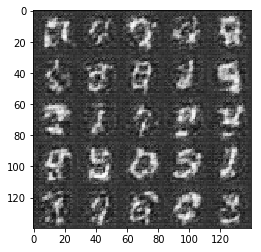

Epoch 1/2... Discriminator Loss: 1.0510 Generator Loss: 0.5016
Epoch 1/2... Discriminator Loss: 0.6099 Generator Loss: 2.9642
Epoch 1/2... Discriminator Loss: 0.7885 Generator Loss: 2.0934
Epoch 1/2... Discriminator Loss: 1.2449 Generator Loss: 0.4702
Epoch 1/2... Discriminator Loss: 0.1687 Generator Loss: 2.4817
Epoch 1/2... Discriminator Loss: 0.9927 Generator Loss: 0.5770
Epoch 1/2... Discriminator Loss: 0.0618 Generator Loss: 6.4846
Epoch 1/2... Discriminator Loss: 0.0299 Generator Loss: 5.5595
Epoch 1/2... Discriminator Loss: 1.7637 Generator Loss: 1.8882
Epoch 1/2... Discriminator Loss: 0.7184 Generator Loss: 1.9971


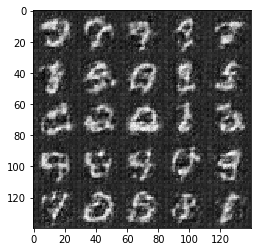

Epoch 1/2... Discriminator Loss: 0.6138 Generator Loss: 2.0050
Epoch 1/2... Discriminator Loss: 0.4580 Generator Loss: 2.3422
Epoch 1/2... Discriminator Loss: 1.4421 Generator Loss: 0.4008
Epoch 1/2... Discriminator Loss: 1.6886 Generator Loss: 0.2680
Epoch 1/2... Discriminator Loss: 0.7647 Generator Loss: 0.8770
Epoch 1/2... Discriminator Loss: 0.8498 Generator Loss: 0.6725
Epoch 1/2... Discriminator Loss: 1.7251 Generator Loss: 4.7194
Epoch 1/2... Discriminator Loss: 1.3377 Generator Loss: 0.6489
Epoch 1/2... Discriminator Loss: 0.6085 Generator Loss: 1.2061
Epoch 1/2... Discriminator Loss: 0.2942 Generator Loss: 1.7453


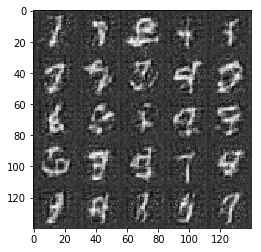

Epoch 1/2... Discriminator Loss: 0.1700 Generator Loss: 3.7134
Epoch 1/2... Discriminator Loss: 0.0603 Generator Loss: 3.7065
Epoch 1/2... Discriminator Loss: 0.1624 Generator Loss: 2.3324
Epoch 1/2... Discriminator Loss: 0.0787 Generator Loss: 3.2454
Epoch 1/2... Discriminator Loss: 0.0194 Generator Loss: 7.1280
Epoch 1/2... Discriminator Loss: 0.0420 Generator Loss: 3.8861
Epoch 1/2... Discriminator Loss: 0.7613 Generator Loss: 0.8816
Epoch 1/2... Discriminator Loss: 4.4685 Generator Loss: 0.0253
Epoch 1/2... Discriminator Loss: 1.6315 Generator Loss: 0.3955
Epoch 1/2... Discriminator Loss: 1.1071 Generator Loss: 3.5620


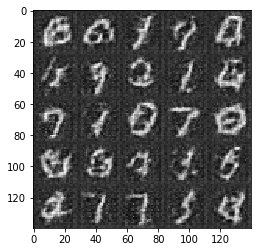

Epoch 1/2... Discriminator Loss: 0.4374 Generator Loss: 1.8566
Epoch 1/2... Discriminator Loss: 0.8859 Generator Loss: 3.0604
Epoch 1/2... Discriminator Loss: 2.3265 Generator Loss: 0.1586
Epoch 1/2... Discriminator Loss: 0.5237 Generator Loss: 2.0155
Epoch 1/2... Discriminator Loss: 0.5214 Generator Loss: 1.8060
Epoch 1/2... Discriminator Loss: 0.3437 Generator Loss: 1.7324
Epoch 1/2... Discriminator Loss: 0.5857 Generator Loss: 1.1025
Epoch 1/2... Discriminator Loss: 0.3335 Generator Loss: 1.5638
Epoch 1/2... Discriminator Loss: 0.0572 Generator Loss: 4.0113
Epoch 1/2... Discriminator Loss: 0.7751 Generator Loss: 4.7200


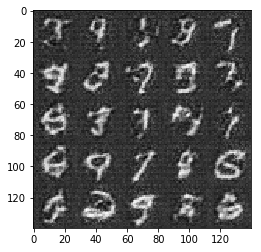

Epoch 1/2... Discriminator Loss: 3.2419 Generator Loss: 0.0622
Epoch 1/2... Discriminator Loss: 0.8363 Generator Loss: 0.8815
Epoch 1/2... Discriminator Loss: 0.8957 Generator Loss: 0.7988
Epoch 1/2... Discriminator Loss: 0.4559 Generator Loss: 1.4460
Epoch 1/2... Discriminator Loss: 0.4351 Generator Loss: 1.5205
Epoch 1/2... Discriminator Loss: 0.5937 Generator Loss: 1.1347
Epoch 1/2... Discriminator Loss: 0.7513 Generator Loss: 0.9949
Epoch 1/2... Discriminator Loss: 0.2020 Generator Loss: 2.5618
Epoch 1/2... Discriminator Loss: 0.2788 Generator Loss: 1.7320
Epoch 1/2... Discriminator Loss: 0.3480 Generator Loss: 1.5623


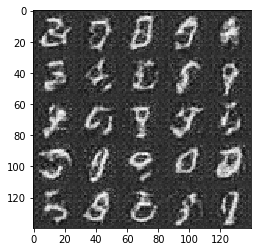

Epoch 1/2... Discriminator Loss: 0.0257 Generator Loss: 5.0161
Epoch 1/2... Discriminator Loss: 0.0728 Generator Loss: 3.8326
Epoch 1/2... Discriminator Loss: 0.1795 Generator Loss: 2.1290
Epoch 1/2... Discriminator Loss: 0.4758 Generator Loss: 1.2004
Epoch 1/2... Discriminator Loss: 0.0311 Generator Loss: 5.1650
Epoch 1/2... Discriminator Loss: 0.0068 Generator Loss: 7.5475
Epoch 1/2... Discriminator Loss: 0.0113 Generator Loss: 5.6638
Epoch 1/2... Discriminator Loss: 2.3991 Generator Loss: 0.1209
Epoch 1/2... Discriminator Loss: 3.3039 Generator Loss: 5.8559
Epoch 1/2... Discriminator Loss: 0.7366 Generator Loss: 1.8529


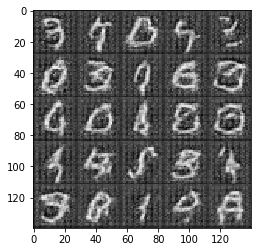

Epoch 1/2... Discriminator Loss: 0.5160 Generator Loss: 1.6711
Epoch 1/2... Discriminator Loss: 0.7970 Generator Loss: 1.0212
Epoch 1/2... Discriminator Loss: 0.7933 Generator Loss: 0.7580
Epoch 1/2... Discriminator Loss: 0.6876 Generator Loss: 0.9689
Epoch 1/2... Discriminator Loss: 0.6899 Generator Loss: 1.0239
Epoch 1/2... Discriminator Loss: 0.7012 Generator Loss: 0.9968
Epoch 1/2... Discriminator Loss: 0.1923 Generator Loss: 2.2350
Epoch 1/2... Discriminator Loss: 0.0634 Generator Loss: 4.3395
Epoch 1/2... Discriminator Loss: 0.0770 Generator Loss: 3.1583
Epoch 1/2... Discriminator Loss: 0.0589 Generator Loss: 3.3654


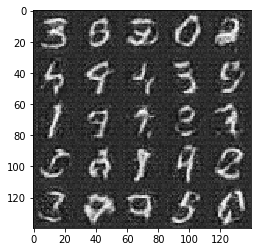

Epoch 1/2... Discriminator Loss: 0.6306 Generator Loss: 4.9217
Epoch 1/2... Discriminator Loss: 0.7666 Generator Loss: 1.1495
Epoch 1/2... Discriminator Loss: 0.4744 Generator Loss: 2.3700
Epoch 1/2... Discriminator Loss: 0.7633 Generator Loss: 0.9131
Epoch 1/2... Discriminator Loss: 0.3901 Generator Loss: 1.5559
Epoch 1/2... Discriminator Loss: 0.8135 Generator Loss: 1.0710
Epoch 1/2... Discriminator Loss: 0.3984 Generator Loss: 2.1660
Epoch 1/2... Discriminator Loss: 0.5976 Generator Loss: 1.3078
Epoch 1/2... Discriminator Loss: 0.1678 Generator Loss: 2.4509
Epoch 1/2... Discriminator Loss: 0.1448 Generator Loss: 2.7959


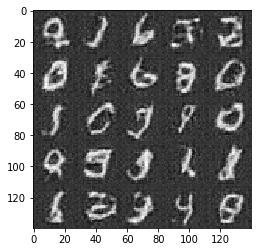

Epoch 1/2... Discriminator Loss: 0.0412 Generator Loss: 4.3906
Epoch 1/2... Discriminator Loss: 0.0580 Generator Loss: 4.5163
Epoch 1/2... Discriminator Loss: 0.0218 Generator Loss: 6.3278
Epoch 1/2... Discriminator Loss: 0.0317 Generator Loss: 6.2062
Epoch 1/2... Discriminator Loss: 0.0798 Generator Loss: 3.3621
Epoch 1/2... Discriminator Loss: 0.0130 Generator Loss: 7.8570
Epoch 1/2... Discriminator Loss: 0.0153 Generator Loss: 5.5699
Epoch 1/2... Discriminator Loss: 2.9942 Generator Loss: 3.7587
Epoch 1/2... Discriminator Loss: 1.3328 Generator Loss: 0.5196
Epoch 1/2... Discriminator Loss: 0.4596 Generator Loss: 1.6455


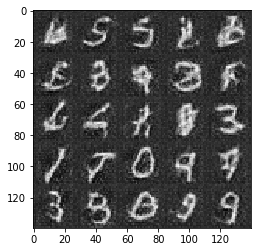

Epoch 1/2... Discriminator Loss: 0.5076 Generator Loss: 1.8735
Epoch 1/2... Discriminator Loss: 0.5724 Generator Loss: 1.1781
Epoch 1/2... Discriminator Loss: 0.7535 Generator Loss: 3.0796
Epoch 1/2... Discriminator Loss: 0.3474 Generator Loss: 1.9288
Epoch 1/2... Discriminator Loss: 0.3106 Generator Loss: 3.0610
Epoch 1/2... Discriminator Loss: 0.2344 Generator Loss: 2.1873
Epoch 1/2... Discriminator Loss: 0.2187 Generator Loss: 2.0320
Epoch 1/2... Discriminator Loss: 0.0980 Generator Loss: 5.2981
Epoch 1/2... Discriminator Loss: 0.3581 Generator Loss: 1.7798
Epoch 1/2... Discriminator Loss: 0.4379 Generator Loss: 1.4084


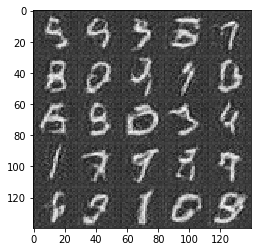

Epoch 1/2... Discriminator Loss: 0.0706 Generator Loss: 5.1975
Epoch 1/2... Discriminator Loss: 0.0259 Generator Loss: 5.1229
Epoch 1/2... Discriminator Loss: 0.0547 Generator Loss: 3.7990
Epoch 1/2... Discriminator Loss: 0.1501 Generator Loss: 2.4443
Epoch 1/2... Discriminator Loss: 0.0535 Generator Loss: 3.7505
Epoch 1/2... Discriminator Loss: 0.0386 Generator Loss: 5.0126
Epoch 1/2... Discriminator Loss: 0.0603 Generator Loss: 3.6281
Epoch 1/2... Discriminator Loss: 0.0201 Generator Loss: 6.4917
Epoch 1/2... Discriminator Loss: 0.0054 Generator Loss: 6.0113
Epoch 1/2... Discriminator Loss: 3.5364 Generator Loss: 6.9298


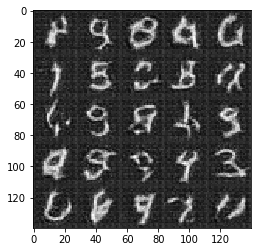

Epoch 1/2... Discriminator Loss: 0.6318 Generator Loss: 1.4199
Epoch 1/2... Discriminator Loss: 1.0660 Generator Loss: 0.6139
Epoch 1/2... Discriminator Loss: 0.7407 Generator Loss: 1.0807
Epoch 1/2... Discriminator Loss: 0.9916 Generator Loss: 0.6461
Epoch 1/2... Discriminator Loss: 0.1522 Generator Loss: 2.7085
Epoch 1/2... Discriminator Loss: 0.4551 Generator Loss: 1.4092
Epoch 1/2... Discriminator Loss: 0.8166 Generator Loss: 0.9667
Epoch 1/2... Discriminator Loss: 2.4106 Generator Loss: 0.3192
Epoch 1/2... Discriminator Loss: 0.7656 Generator Loss: 1.2697
Epoch 1/2... Discriminator Loss: 0.3571 Generator Loss: 2.0831


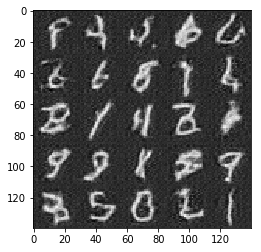

Epoch 1/2... Discriminator Loss: 0.3276 Generator Loss: 1.9285
Epoch 1/2... Discriminator Loss: 0.4528 Generator Loss: 1.4307
Epoch 1/2... Discriminator Loss: 0.2967 Generator Loss: 2.4964
Epoch 1/2... Discriminator Loss: 1.1826 Generator Loss: 0.5363
Epoch 1/2... Discriminator Loss: 0.4039 Generator Loss: 2.0686
Epoch 1/2... Discriminator Loss: 0.1017 Generator Loss: 2.8866
Epoch 1/2... Discriminator Loss: 0.2734 Generator Loss: 2.0927
Epoch 2/2... Discriminator Loss: 0.0917 Generator Loss: 2.9261
Epoch 2/2... Discriminator Loss: 0.3369 Generator Loss: 1.6293
Epoch 2/2... Discriminator Loss: 0.1428 Generator Loss: 2.5256


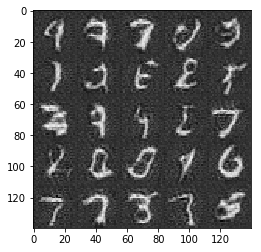

Epoch 2/2... Discriminator Loss: 0.3948 Generator Loss: 1.5836
Epoch 2/2... Discriminator Loss: 0.1341 Generator Loss: 2.3338
Epoch 2/2... Discriminator Loss: 0.0232 Generator Loss: 4.5501
Epoch 2/2... Discriminator Loss: 0.0511 Generator Loss: 3.8642
Epoch 2/2... Discriminator Loss: 0.0749 Generator Loss: 3.3436
Epoch 2/2... Discriminator Loss: 0.0401 Generator Loss: 3.9997
Epoch 2/2... Discriminator Loss: 0.0201 Generator Loss: 4.6202
Epoch 2/2... Discriminator Loss: 0.0174 Generator Loss: 5.1198
Epoch 2/2... Discriminator Loss: 0.0131 Generator Loss: 5.1075
Epoch 2/2... Discriminator Loss: 0.0877 Generator Loss: 2.9599


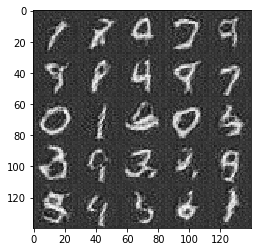

Epoch 2/2... Discriminator Loss: 0.0037 Generator Loss: 7.4588
Epoch 2/2... Discriminator Loss: 0.2591 Generator Loss: 1.8946
Epoch 2/2... Discriminator Loss: 0.0743 Generator Loss: 3.1200
Epoch 2/2... Discriminator Loss: 0.0100 Generator Loss: 7.6400
Epoch 2/2... Discriminator Loss: 0.0118 Generator Loss: 5.3286
Epoch 2/2... Discriminator Loss: 0.0157 Generator Loss: 4.7455
Epoch 2/2... Discriminator Loss: 0.2857 Generator Loss: 1.8530
Epoch 2/2... Discriminator Loss: 0.0095 Generator Loss: 6.8606
Epoch 2/2... Discriminator Loss: 0.2288 Generator Loss: 2.0808
Epoch 2/2... Discriminator Loss: 0.0703 Generator Loss: 3.2497


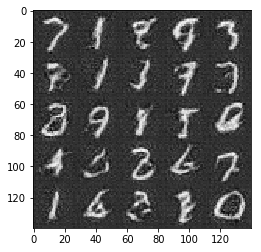

Epoch 2/2... Discriminator Loss: 0.0263 Generator Loss: 4.4966
Epoch 2/2... Discriminator Loss: 0.7513 Generator Loss: 0.9634
Epoch 2/2... Discriminator Loss: 1.7026 Generator Loss: 0.7760
Epoch 2/2... Discriminator Loss: 0.5615 Generator Loss: 3.0887
Epoch 2/2... Discriminator Loss: 0.3774 Generator Loss: 1.6047
Epoch 2/2... Discriminator Loss: 0.1877 Generator Loss: 3.4263
Epoch 2/2... Discriminator Loss: 0.7058 Generator Loss: 1.7457
Epoch 2/2... Discriminator Loss: 0.3338 Generator Loss: 1.9797
Epoch 2/2... Discriminator Loss: 0.4991 Generator Loss: 1.3324
Epoch 2/2... Discriminator Loss: 0.0269 Generator Loss: 5.0926


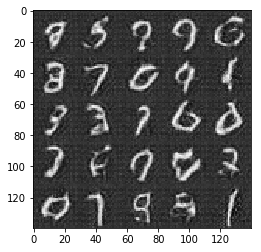

Epoch 2/2... Discriminator Loss: 0.1058 Generator Loss: 4.4484
Epoch 2/2... Discriminator Loss: 1.6966 Generator Loss: 0.4806
Epoch 2/2... Discriminator Loss: 1.9753 Generator Loss: 0.3907
Epoch 2/2... Discriminator Loss: 0.6617 Generator Loss: 1.1533
Epoch 2/2... Discriminator Loss: 0.6418 Generator Loss: 0.9872
Epoch 2/2... Discriminator Loss: 0.8232 Generator Loss: 0.8316
Epoch 2/2... Discriminator Loss: 0.0897 Generator Loss: 3.4143
Epoch 2/2... Discriminator Loss: 0.3081 Generator Loss: 1.8807
Epoch 2/2... Discriminator Loss: 0.0635 Generator Loss: 3.3600
Epoch 2/2... Discriminator Loss: 0.0741 Generator Loss: 3.6754


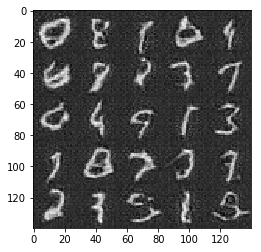

Epoch 2/2... Discriminator Loss: 0.2210 Generator Loss: 2.2876
Epoch 2/2... Discriminator Loss: 0.1305 Generator Loss: 3.3860
Epoch 2/2... Discriminator Loss: 0.1565 Generator Loss: 2.6548
Epoch 2/2... Discriminator Loss: 0.0122 Generator Loss: 5.5233
Epoch 2/2... Discriminator Loss: 0.4868 Generator Loss: 1.2239
Epoch 2/2... Discriminator Loss: 0.0223 Generator Loss: 4.4125
Epoch 2/2... Discriminator Loss: 0.7136 Generator Loss: 3.1678
Epoch 2/2... Discriminator Loss: 0.4598 Generator Loss: 1.9085
Epoch 2/2... Discriminator Loss: 0.2570 Generator Loss: 2.0665
Epoch 2/2... Discriminator Loss: 0.2782 Generator Loss: 2.3097


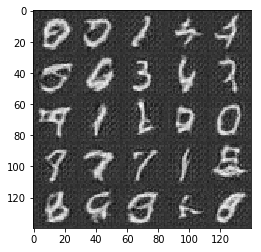

Epoch 2/2... Discriminator Loss: 0.3203 Generator Loss: 3.5120
Epoch 2/2... Discriminator Loss: 0.8261 Generator Loss: 0.8932
Epoch 2/2... Discriminator Loss: 0.0752 Generator Loss: 4.0454
Epoch 2/2... Discriminator Loss: 0.5245 Generator Loss: 1.2836
Epoch 2/2... Discriminator Loss: 0.8744 Generator Loss: 1.8814
Epoch 2/2... Discriminator Loss: 0.3740 Generator Loss: 2.0649
Epoch 2/2... Discriminator Loss: 0.3972 Generator Loss: 1.8569
Epoch 2/2... Discriminator Loss: 0.1949 Generator Loss: 2.5225
Epoch 2/2... Discriminator Loss: 0.0856 Generator Loss: 3.3905
Epoch 2/2... Discriminator Loss: 0.7782 Generator Loss: 0.8187


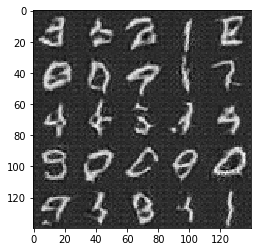

Epoch 2/2... Discriminator Loss: 0.6299 Generator Loss: 1.2333
Epoch 2/2... Discriminator Loss: 0.0690 Generator Loss: 3.1027
Epoch 2/2... Discriminator Loss: 0.8426 Generator Loss: 0.8768
Epoch 2/2... Discriminator Loss: 0.0314 Generator Loss: 5.3950
Epoch 2/2... Discriminator Loss: 0.0161 Generator Loss: 4.7222
Epoch 2/2... Discriminator Loss: 0.0211 Generator Loss: 5.1057
Epoch 2/2... Discriminator Loss: 0.0252 Generator Loss: 4.5847
Epoch 2/2... Discriminator Loss: 0.0159 Generator Loss: 5.1292
Epoch 2/2... Discriminator Loss: 0.0213 Generator Loss: 5.3739
Epoch 2/2... Discriminator Loss: 0.0129 Generator Loss: 5.2016


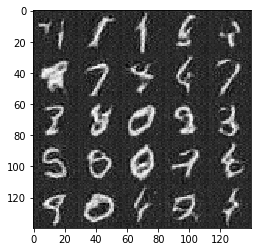

Epoch 2/2... Discriminator Loss: 0.6426 Generator Loss: 5.1239
Epoch 2/2... Discriminator Loss: 0.3941 Generator Loss: 2.8802
Epoch 2/2... Discriminator Loss: 0.3492 Generator Loss: 1.7502
Epoch 2/2... Discriminator Loss: 0.3894 Generator Loss: 1.7458
Epoch 2/2... Discriminator Loss: 0.6581 Generator Loss: 1.0955
Epoch 2/2... Discriminator Loss: 0.3629 Generator Loss: 1.7850
Epoch 2/2... Discriminator Loss: 7.7065 Generator Loss: 7.2899
Epoch 2/2... Discriminator Loss: 0.6775 Generator Loss: 2.1392
Epoch 2/2... Discriminator Loss: 0.6066 Generator Loss: 1.2483
Epoch 2/2... Discriminator Loss: 0.2603 Generator Loss: 2.6276


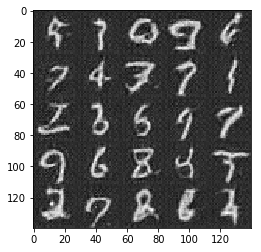

Epoch 2/2... Discriminator Loss: 0.4000 Generator Loss: 1.7821
Epoch 2/2... Discriminator Loss: 0.4636 Generator Loss: 2.2029
Epoch 2/2... Discriminator Loss: 0.8779 Generator Loss: 0.9014
Epoch 2/2... Discriminator Loss: 0.4501 Generator Loss: 3.0642
Epoch 2/2... Discriminator Loss: 0.4043 Generator Loss: 2.8235
Epoch 2/2... Discriminator Loss: 0.6376 Generator Loss: 1.1859
Epoch 2/2... Discriminator Loss: 0.3626 Generator Loss: 1.7229
Epoch 2/2... Discriminator Loss: 0.3322 Generator Loss: 2.1437
Epoch 2/2... Discriminator Loss: 0.5601 Generator Loss: 1.1622
Epoch 2/2... Discriminator Loss: 0.2849 Generator Loss: 1.7554


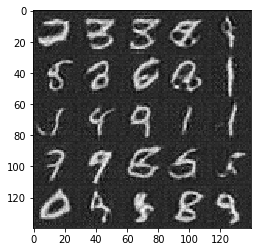

Epoch 2/2... Discriminator Loss: 0.0335 Generator Loss: 4.1467
Epoch 2/2... Discriminator Loss: 0.2711 Generator Loss: 2.2232
Epoch 2/2... Discriminator Loss: 0.0681 Generator Loss: 3.3985
Epoch 2/2... Discriminator Loss: 0.0637 Generator Loss: 3.2615
Epoch 2/2... Discriminator Loss: 0.0193 Generator Loss: 4.8265
Epoch 2/2... Discriminator Loss: 0.1141 Generator Loss: 2.8347
Epoch 2/2... Discriminator Loss: 0.0226 Generator Loss: 4.6047
Epoch 2/2... Discriminator Loss: 4.0932 Generator Loss: 0.1415
Epoch 2/2... Discriminator Loss: 0.4016 Generator Loss: 2.1238
Epoch 2/2... Discriminator Loss: 0.7717 Generator Loss: 0.8623


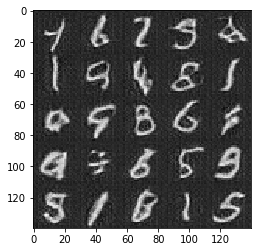

Epoch 2/2... Discriminator Loss: 0.6251 Generator Loss: 1.0330
Epoch 2/2... Discriminator Loss: 0.4232 Generator Loss: 1.5313
Epoch 2/2... Discriminator Loss: 0.4555 Generator Loss: 1.3531
Epoch 2/2... Discriminator Loss: 0.6818 Generator Loss: 1.1061
Epoch 2/2... Discriminator Loss: 1.3362 Generator Loss: 6.0432
Epoch 2/2... Discriminator Loss: 1.9784 Generator Loss: 4.1091
Epoch 2/2... Discriminator Loss: 0.4690 Generator Loss: 1.6213
Epoch 2/2... Discriminator Loss: 0.8418 Generator Loss: 0.7684
Epoch 2/2... Discriminator Loss: 0.4037 Generator Loss: 1.6932
Epoch 2/2... Discriminator Loss: 0.3228 Generator Loss: 1.8644


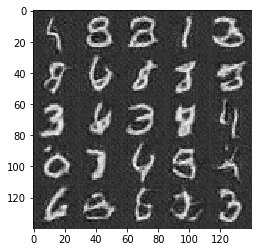

Epoch 2/2... Discriminator Loss: 0.5089 Generator Loss: 3.8919
Epoch 2/2... Discriminator Loss: 0.3237 Generator Loss: 1.9383
Epoch 2/2... Discriminator Loss: 0.2951 Generator Loss: 1.8566
Epoch 2/2... Discriminator Loss: 0.6356 Generator Loss: 1.1235
Epoch 2/2... Discriminator Loss: 0.1625 Generator Loss: 2.4454
Epoch 2/2... Discriminator Loss: 0.1932 Generator Loss: 2.2010
Epoch 2/2... Discriminator Loss: 0.1336 Generator Loss: 2.6577
Epoch 2/2... Discriminator Loss: 0.2132 Generator Loss: 2.0570
Epoch 2/2... Discriminator Loss: 0.1706 Generator Loss: 2.2087
Epoch 2/2... Discriminator Loss: 0.1369 Generator Loss: 2.3917


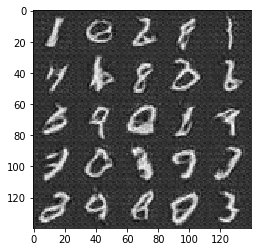

Epoch 2/2... Discriminator Loss: 0.0629 Generator Loss: 3.3569
Epoch 2/2... Discriminator Loss: 0.0158 Generator Loss: 4.9041
Epoch 2/2... Discriminator Loss: 0.1363 Generator Loss: 2.5165
Epoch 2/2... Discriminator Loss: 0.0624 Generator Loss: 3.4839
Epoch 2/2... Discriminator Loss: 0.0387 Generator Loss: 4.1071
Epoch 2/2... Discriminator Loss: 0.0375 Generator Loss: 4.0797
Epoch 2/2... Discriminator Loss: 0.0171 Generator Loss: 6.6262
Epoch 2/2... Discriminator Loss: 0.5089 Generator Loss: 1.4730
Epoch 2/2... Discriminator Loss: 0.0340 Generator Loss: 4.2257
Epoch 2/2... Discriminator Loss: 0.0503 Generator Loss: 4.0086


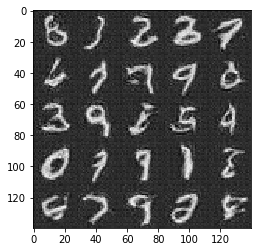

Epoch 2/2... Discriminator Loss: 0.1074 Generator Loss: 2.9664
Epoch 2/2... Discriminator Loss: 0.0744 Generator Loss: 3.5057
Epoch 2/2... Discriminator Loss: 0.3968 Generator Loss: 1.5752
Epoch 2/2... Discriminator Loss: 0.0148 Generator Loss: 5.5267
Epoch 2/2... Discriminator Loss: 0.0992 Generator Loss: 2.8200
Epoch 2/2... Discriminator Loss: 0.0449 Generator Loss: 3.7715
Epoch 2/2... Discriminator Loss: 0.1114 Generator Loss: 2.7330
Epoch 2/2... Discriminator Loss: 0.1488 Generator Loss: 2.3039
Epoch 2/2... Discriminator Loss: 0.4506 Generator Loss: 1.3880
Epoch 2/2... Discriminator Loss: 0.1494 Generator Loss: 2.3953


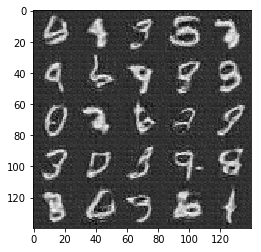

Epoch 2/2... Discriminator Loss: 0.0124 Generator Loss: 5.7162
Epoch 2/2... Discriminator Loss: 0.0319 Generator Loss: 4.2320
Epoch 2/2... Discriminator Loss: 0.1427 Generator Loss: 2.5713
Epoch 2/2... Discriminator Loss: 1.9083 Generator Loss: 0.3228
Epoch 2/2... Discriminator Loss: 0.0516 Generator Loss: 4.9758
Epoch 2/2... Discriminator Loss: 0.0089 Generator Loss: 6.2365
Epoch 2/2... Discriminator Loss: 0.0084 Generator Loss: 6.9275
Epoch 2/2... Discriminator Loss: 0.0178 Generator Loss: 4.4390
Epoch 2/2... Discriminator Loss: 0.0588 Generator Loss: 3.4391
Epoch 2/2... Discriminator Loss: 0.0485 Generator Loss: 4.3489


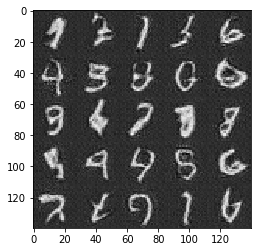

Epoch 2/2... Discriminator Loss: 0.0035 Generator Loss: 8.1623
Epoch 2/2... Discriminator Loss: 0.0098 Generator Loss: 5.2926
Epoch 2/2... Discriminator Loss: 0.0805 Generator Loss: 3.1700
Epoch 2/2... Discriminator Loss: 0.1096 Generator Loss: 2.8459
Epoch 2/2... Discriminator Loss: 0.0677 Generator Loss: 3.2832
Epoch 2/2... Discriminator Loss: 1.3820 Generator Loss: 4.7230
Epoch 2/2... Discriminator Loss: 0.4683 Generator Loss: 2.0264
Epoch 2/2... Discriminator Loss: 0.8750 Generator Loss: 1.1692
Epoch 2/2... Discriminator Loss: 0.4793 Generator Loss: 2.5900
Epoch 2/2... Discriminator Loss: 0.4277 Generator Loss: 1.9465


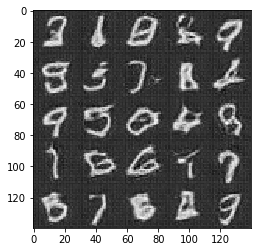

Epoch 2/2... Discriminator Loss: 0.7261 Generator Loss: 1.2839
Epoch 2/2... Discriminator Loss: 0.3092 Generator Loss: 2.2952
Epoch 2/2... Discriminator Loss: 0.2123 Generator Loss: 3.0933
Epoch 2/2... Discriminator Loss: 0.4584 Generator Loss: 1.5668
Epoch 2/2... Discriminator Loss: 0.3559 Generator Loss: 3.2319
Epoch 2/2... Discriminator Loss: 0.5170 Generator Loss: 1.2239
Epoch 2/2... Discriminator Loss: 0.3373 Generator Loss: 1.9547
Epoch 2/2... Discriminator Loss: 0.3545 Generator Loss: 3.9435
Epoch 2/2... Discriminator Loss: 0.6102 Generator Loss: 1.1333
Epoch 2/2... Discriminator Loss: 0.3670 Generator Loss: 3.1700


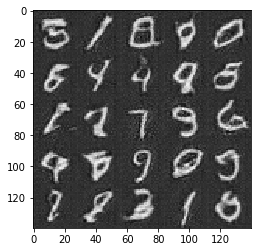

Epoch 2/2... Discriminator Loss: 0.6216 Generator Loss: 1.6098
Epoch 2/2... Discriminator Loss: 0.7256 Generator Loss: 1.2968
Epoch 2/2... Discriminator Loss: 0.6433 Generator Loss: 1.2078
Epoch 2/2... Discriminator Loss: 0.3640 Generator Loss: 1.6183
Epoch 2/2... Discriminator Loss: 0.2543 Generator Loss: 2.9592
Epoch 2/2... Discriminator Loss: 1.0799 Generator Loss: 0.8738
Epoch 2/2... Discriminator Loss: 0.3984 Generator Loss: 1.6322
Epoch 2/2... Discriminator Loss: 0.4988 Generator Loss: 1.5065
Epoch 2/2... Discriminator Loss: 2.5367 Generator Loss: 0.1148
Epoch 2/2... Discriminator Loss: 0.8073 Generator Loss: 0.9607


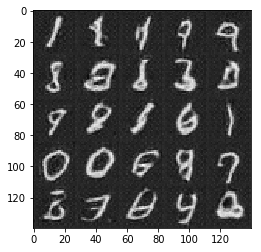

Epoch 2/2... Discriminator Loss: 0.2295 Generator Loss: 2.2819
Epoch 2/2... Discriminator Loss: 0.2145 Generator Loss: 2.0825
Epoch 2/2... Discriminator Loss: 0.2641 Generator Loss: 1.9320
Epoch 2/2... Discriminator Loss: 0.4731 Generator Loss: 1.1929
Epoch 2/2... Discriminator Loss: 0.4659 Generator Loss: 1.3637
Final Output


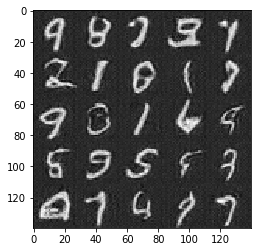

In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0649 Generator Loss: 16.7858
Epoch 1/1... Discriminator Loss: 0.3165 Generator Loss: 13.5031
Epoch 1/1... Discriminator Loss: 1.7403 Generator Loss: 5.2079
Epoch 1/1... Discriminator Loss: 1.1208 Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.0318 Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 0.2191 Generator Loss: 2.6315
Epoch 1/1... Discriminator Loss: 0.1043 Generator Loss: 3.0975
Epoch 1/1... Discriminator Loss: 1.2381 Generator Loss: 13.1295
Epoch 1/1... Discriminator Loss: 0.0055 Generator Loss: 9.4662
Epoch 1/1... Discriminator Loss: 0.0037 Generator Loss: 7.0578


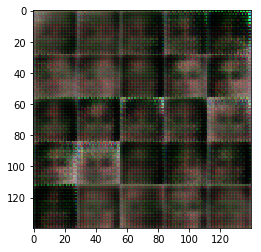

Epoch 1/1... Discriminator Loss: 6.1982 Generator Loss: 13.0459
Epoch 1/1... Discriminator Loss: 3.6568 Generator Loss: 0.0411
Epoch 1/1... Discriminator Loss: 0.4023 Generator Loss: 2.9377
Epoch 1/1... Discriminator Loss: 0.0294 Generator Loss: 5.2958
Epoch 1/1... Discriminator Loss: 0.3682 Generator Loss: 6.7216
Epoch 1/1... Discriminator Loss: 0.2476 Generator Loss: 1.9040
Epoch 1/1... Discriminator Loss: 0.1020 Generator Loss: 4.3321
Epoch 1/1... Discriminator Loss: 0.5349 Generator Loss: 1.6116
Epoch 1/1... Discriminator Loss: 0.5945 Generator Loss: 1.3275
Epoch 1/1... Discriminator Loss: 0.2936 Generator Loss: 1.8166


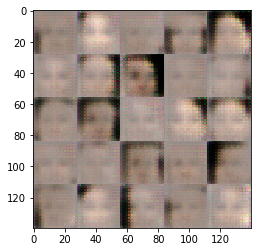

Epoch 1/1... Discriminator Loss: 1.2128 Generator Loss: 7.0355
Epoch 1/1... Discriminator Loss: 0.7702 Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 0.3815 Generator Loss: 1.7031
Epoch 1/1... Discriminator Loss: 0.0206 Generator Loss: 4.3940
Epoch 1/1... Discriminator Loss: 2.8294 Generator Loss: 8.4338
Epoch 1/1... Discriminator Loss: 0.2280 Generator Loss: 3.5566
Epoch 1/1... Discriminator Loss: 0.2212 Generator Loss: 1.9795
Epoch 1/1... Discriminator Loss: 6.6358 Generator Loss: 0.0032
Epoch 1/1... Discriminator Loss: 1.0169 Generator Loss: 1.0593
Epoch 1/1... Discriminator Loss: 0.7047 Generator Loss: 1.0506


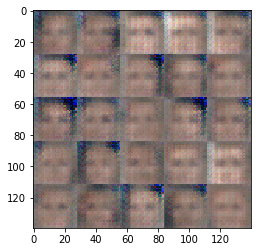

Epoch 1/1... Discriminator Loss: 0.1881 Generator Loss: 3.2308
Epoch 1/1... Discriminator Loss: 0.2343 Generator Loss: 2.4590
Epoch 1/1... Discriminator Loss: 0.0171 Generator Loss: 6.2926
Epoch 1/1... Discriminator Loss: 0.7379 Generator Loss: 1.2308
Epoch 1/1... Discriminator Loss: 0.4803 Generator Loss: 3.1626
Epoch 1/1... Discriminator Loss: 0.0413 Generator Loss: 5.7855
Epoch 1/1... Discriminator Loss: 0.4545 Generator Loss: 1.6971
Epoch 1/1... Discriminator Loss: 0.5200 Generator Loss: 3.3318
Epoch 1/1... Discriminator Loss: 0.6607 Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 0.4346 Generator Loss: 1.5603


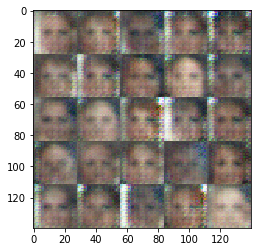

Epoch 1/1... Discriminator Loss: 0.0262 Generator Loss: 5.5279
Epoch 1/1... Discriminator Loss: 3.8067 Generator Loss: 5.6993
Epoch 1/1... Discriminator Loss: 1.4897 Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 0.9575 Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 0.5147 Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 3.4476 Generator Loss: 5.0749
Epoch 1/1... Discriminator Loss: 0.1270 Generator Loss: 2.5054
Epoch 1/1... Discriminator Loss: 0.4356 Generator Loss: 2.3347
Epoch 1/1... Discriminator Loss: 1.3205 Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.2118 Generator Loss: 0.6882


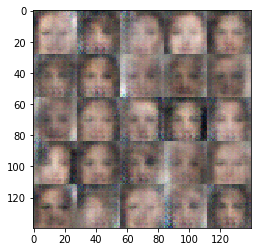

Epoch 1/1... Discriminator Loss: 1.1322 Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 0.6865 Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 0.0698 Generator Loss: 3.3761
Epoch 1/1... Discriminator Loss: 0.0543 Generator Loss: 5.2644
Epoch 1/1... Discriminator Loss: 0.7428 Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 0.7392 Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 2.3876 Generator Loss: 0.1392
Epoch 1/1... Discriminator Loss: 1.7317 Generator Loss: 0.5516
Epoch 1/1... Discriminator Loss: 1.3900 Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.2429 Generator Loss: 0.9146


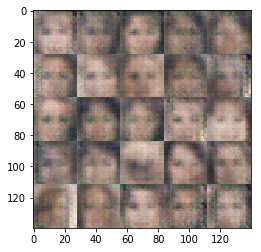

Epoch 1/1... Discriminator Loss: 1.8162 Generator Loss: 0.2334
Epoch 1/1... Discriminator Loss: 1.4261 Generator Loss: 1.2195
Epoch 1/1... Discriminator Loss: 1.0539 Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.3321 Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 1.3270 Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.4211 Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.3202 Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 0.8836 Generator Loss: 0.9647
Epoch 1/1... Discriminator Loss: 0.6510 Generator Loss: 1.7354
Epoch 1/1... Discriminator Loss: 1.3615 Generator Loss: 2.8273


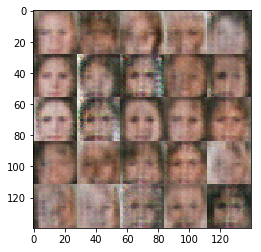

Epoch 1/1... Discriminator Loss: 0.4369 Generator Loss: 1.5821
Epoch 1/1... Discriminator Loss: 1.0804 Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 0.7366 Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.2173 Generator Loss: 0.4653
Epoch 1/1... Discriminator Loss: 2.9955 Generator Loss: 5.1682
Epoch 1/1... Discriminator Loss: 1.0612 Generator Loss: 1.5757
Epoch 1/1... Discriminator Loss: 0.2956 Generator Loss: 1.6819
Epoch 1/1... Discriminator Loss: 0.5882 Generator Loss: 3.8195
Epoch 1/1... Discriminator Loss: 1.3229 Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 0.4648 Generator Loss: 1.4844


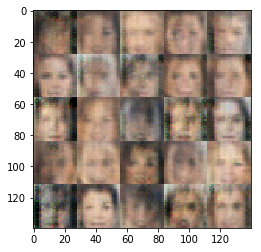

Epoch 1/1... Discriminator Loss: 1.8345 Generator Loss: 0.2203
Epoch 1/1... Discriminator Loss: 0.1568 Generator Loss: 2.0867
Epoch 1/1... Discriminator Loss: 0.0527 Generator Loss: 3.3740
Epoch 1/1... Discriminator Loss: 0.8518 Generator Loss: 1.4125
Epoch 1/1... Discriminator Loss: 2.0814 Generator Loss: 0.2020
Epoch 1/1... Discriminator Loss: 1.2214 Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 0.2131 Generator Loss: 2.4340
Epoch 1/1... Discriminator Loss: 1.3379 Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.1810 Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.6505 Generator Loss: 1.0408


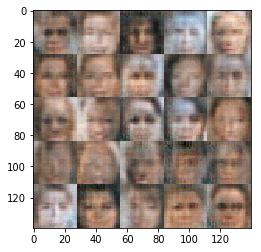

Epoch 1/1... Discriminator Loss: 0.7715 Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.2984 Generator Loss: 0.4114
Epoch 1/1... Discriminator Loss: 1.3365 Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 0.9962 Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.0427 Generator Loss: 1.2560
Epoch 1/1... Discriminator Loss: 0.3868 Generator Loss: 2.1482
Epoch 1/1... Discriminator Loss: 1.6711 Generator Loss: 0.2759
Epoch 1/1... Discriminator Loss: 0.9908 Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 0.7740 Generator Loss: 1.2730
Epoch 1/1... Discriminator Loss: 1.1036 Generator Loss: 1.9607


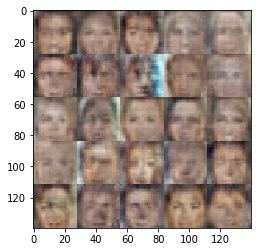

Epoch 1/1... Discriminator Loss: 1.3947 Generator Loss: 0.4199
Epoch 1/1... Discriminator Loss: 1.5154 Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.2284 Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.8286 Generator Loss: 0.2314
Epoch 1/1... Discriminator Loss: 1.1099 Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.0639 Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.3557 Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 1.0006 Generator Loss: 1.2244
Epoch 1/1... Discriminator Loss: 1.1526 Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 4.8307 Generator Loss: 4.4766


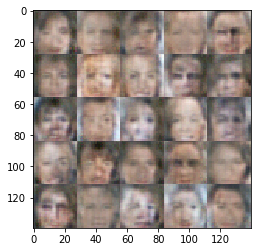

Epoch 1/1... Discriminator Loss: 1.6025 Generator Loss: 0.4366
Epoch 1/1... Discriminator Loss: 1.4166 Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.4579 Generator Loss: 0.4680
Epoch 1/1... Discriminator Loss: 0.6701 Generator Loss: 1.1396
Epoch 1/1... Discriminator Loss: 1.8450 Generator Loss: 0.2349
Epoch 1/1... Discriminator Loss: 1.4156 Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.1718 Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 1.7257 Generator Loss: 0.2548
Epoch 1/1... Discriminator Loss: 0.2856 Generator Loss: 2.7063
Epoch 1/1... Discriminator Loss: 1.5379 Generator Loss: 0.6253


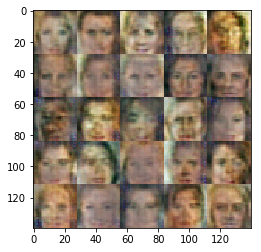

Epoch 1/1... Discriminator Loss: 0.9799 Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.3528 Generator Loss: 0.4507
Epoch 1/1... Discriminator Loss: 1.3313 Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 1.4479 Generator Loss: 0.4576
Epoch 1/1... Discriminator Loss: 1.2587 Generator Loss: 0.5325
Epoch 1/1... Discriminator Loss: 1.2637 Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.2519 Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.2037 Generator Loss: 1.5588
Epoch 1/1... Discriminator Loss: 1.1999 Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 0.7536 Generator Loss: 0.9019


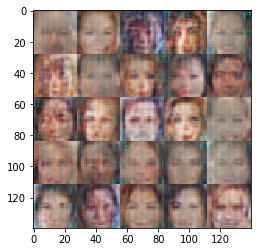

Epoch 1/1... Discriminator Loss: 2.2285 Generator Loss: 2.3789
Epoch 1/1... Discriminator Loss: 1.6429 Generator Loss: 0.3156
Epoch 1/1... Discriminator Loss: 1.3249 Generator Loss: 1.1935
Epoch 1/1... Discriminator Loss: 1.4998 Generator Loss: 2.0036
Epoch 1/1... Discriminator Loss: 1.2569 Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.4947 Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.1073 Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.4224 Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 1.2307 Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.3020 Generator Loss: 1.2404


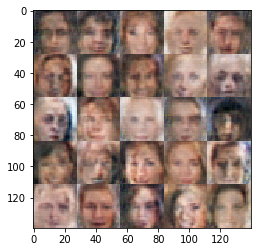

Epoch 1/1... Discriminator Loss: 1.1721 Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.3753 Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.2651 Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.5639 Generator Loss: 0.3443
Epoch 1/1... Discriminator Loss: 1.4235 Generator Loss: 0.3790
Epoch 1/1... Discriminator Loss: 1.2204 Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 0.9103 Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 1.0431 Generator Loss: 2.7147
Epoch 1/1... Discriminator Loss: 1.6072 Generator Loss: 0.2898
Epoch 1/1... Discriminator Loss: 1.2702 Generator Loss: 0.6916


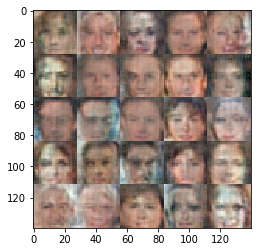

Epoch 1/1... Discriminator Loss: 0.9092 Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 0.8310 Generator Loss: 1.2159
Epoch 1/1... Discriminator Loss: 1.7755 Generator Loss: 0.3643
Epoch 1/1... Discriminator Loss: 1.1485 Generator Loss: 0.5341
Epoch 1/1... Discriminator Loss: 1.1001 Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 0.6442 Generator Loss: 1.2725
Epoch 1/1... Discriminator Loss: 0.8025 Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.0145 Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 2.2793 Generator Loss: 0.1384
Epoch 1/1... Discriminator Loss: 1.3523 Generator Loss: 0.6755


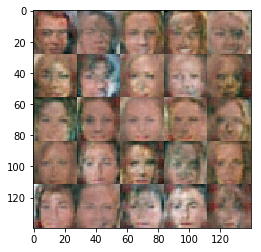

Epoch 1/1... Discriminator Loss: 1.3202 Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 2.5481 Generator Loss: 0.1010
Epoch 1/1... Discriminator Loss: 1.3329 Generator Loss: 0.4705
Epoch 1/1... Discriminator Loss: 1.1771 Generator Loss: 0.4555
Epoch 1/1... Discriminator Loss: 1.4607 Generator Loss: 1.8626
Epoch 1/1... Discriminator Loss: 1.0665 Generator Loss: 0.5687
Epoch 1/1... Discriminator Loss: 0.7007 Generator Loss: 1.2562
Epoch 1/1... Discriminator Loss: 0.2890 Generator Loss: 4.2736
Epoch 1/1... Discriminator Loss: 0.6059 Generator Loss: 2.1024
Epoch 1/1... Discriminator Loss: 1.8637 Generator Loss: 1.2256


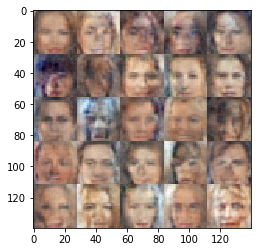

Epoch 1/1... Discriminator Loss: 1.7409 Generator Loss: 0.2723
Epoch 1/1... Discriminator Loss: 1.5531 Generator Loss: 0.3321
Epoch 1/1... Discriminator Loss: 0.8204 Generator Loss: 1.0102
Epoch 1/1... Discriminator Loss: 0.9887 Generator Loss: 2.7251
Epoch 1/1... Discriminator Loss: 0.7597 Generator Loss: 1.1804
Epoch 1/1... Discriminator Loss: 1.5305 Generator Loss: 0.3391
Epoch 1/1... Discriminator Loss: 1.3077 Generator Loss: 1.2965
Epoch 1/1... Discriminator Loss: 0.2650 Generator Loss: 2.8207
Epoch 1/1... Discriminator Loss: 0.6592 Generator Loss: 1.0910
Epoch 1/1... Discriminator Loss: 0.4529 Generator Loss: 1.4810


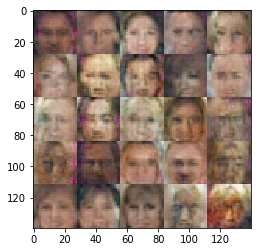

Epoch 1/1... Discriminator Loss: 0.5197 Generator Loss: 1.3440
Epoch 1/1... Discriminator Loss: 0.5742 Generator Loss: 1.2284
Epoch 1/1... Discriminator Loss: 1.4011 Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.3661 Generator Loss: 0.4007
Epoch 1/1... Discriminator Loss: 0.3482 Generator Loss: 1.6544
Epoch 1/1... Discriminator Loss: 1.3706 Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 0.8667 Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 0.2965 Generator Loss: 2.3975
Epoch 1/1... Discriminator Loss: 0.8560 Generator Loss: 1.8115
Epoch 1/1... Discriminator Loss: 0.7530 Generator Loss: 1.1726


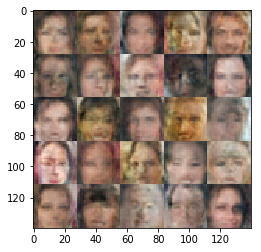

Epoch 1/1... Discriminator Loss: 1.4752 Generator Loss: 0.4094
Epoch 1/1... Discriminator Loss: 1.2069 Generator Loss: 3.2423
Epoch 1/1... Discriminator Loss: 0.8910 Generator Loss: 1.2083
Epoch 1/1... Discriminator Loss: 0.8565 Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.3031 Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.3048 Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.3123 Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.7532 Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.1759 Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.2912 Generator Loss: 0.8941


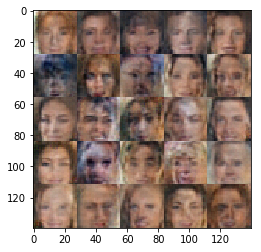

Epoch 1/1... Discriminator Loss: 1.2758 Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.0574 Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.1955 Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.3537 Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 1.2041 Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.0941 Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.1800 Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 0.8932 Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 1.4260 Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.1735 Generator Loss: 0.6638


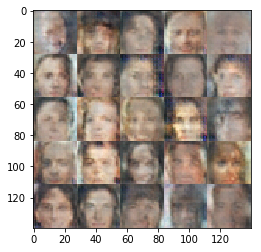

Epoch 1/1... Discriminator Loss: 1.1394 Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.3204 Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 1.3961 Generator Loss: 0.4898
Epoch 1/1... Discriminator Loss: 1.2893 Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.3979 Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.2559 Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.2710 Generator Loss: 0.4505
Epoch 1/1... Discriminator Loss: 1.1840 Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.4523 Generator Loss: 0.4264
Epoch 1/1... Discriminator Loss: 1.0790 Generator Loss: 0.9621


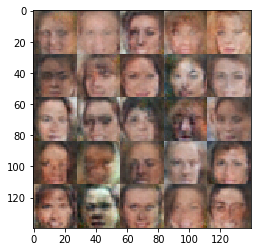

Epoch 1/1... Discriminator Loss: 1.2775 Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.4958 Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.2660 Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 0.9828 Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.5506 Generator Loss: 0.3012
Epoch 1/1... Discriminator Loss: 1.1009 Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.2136 Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.4974 Generator Loss: 0.4166
Epoch 1/1... Discriminator Loss: 1.1595 Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.0281 Generator Loss: 1.0217


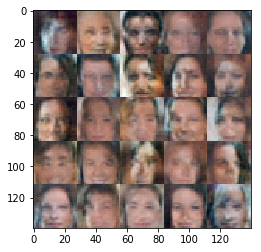

Epoch 1/1... Discriminator Loss: 1.3030 Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.2940 Generator Loss: 1.0806
Epoch 1/1... Discriminator Loss: 1.2650 Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 1.2972 Generator Loss: 0.4964
Epoch 1/1... Discriminator Loss: 1.4415 Generator Loss: 0.3877
Epoch 1/1... Discriminator Loss: 1.0835 Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.3102 Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.2243 Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 1.1912 Generator Loss: 1.2447
Epoch 1/1... Discriminator Loss: 1.3220 Generator Loss: 0.5330


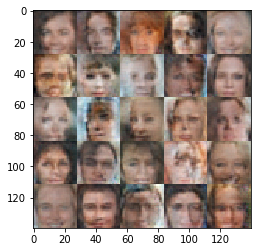

Epoch 1/1... Discriminator Loss: 0.9928 Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 0.9829 Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.2991 Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.5142 Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.0546 Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.5577 Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.3897 Generator Loss: 0.4264
Epoch 1/1... Discriminator Loss: 1.2867 Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.4253 Generator Loss: 0.3705
Epoch 1/1... Discriminator Loss: 1.0132 Generator Loss: 1.0400


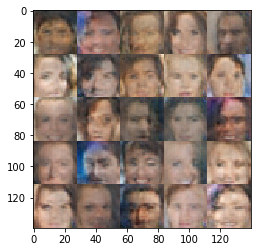

Epoch 1/1... Discriminator Loss: 1.0837 Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.3463 Generator Loss: 1.3699
Epoch 1/1... Discriminator Loss: 0.9971 Generator Loss: 1.0763
Epoch 1/1... Discriminator Loss: 1.2620 Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.0252 Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 1.9845 Generator Loss: 2.2265
Epoch 1/1... Discriminator Loss: 1.4071 Generator Loss: 0.4393
Epoch 1/1... Discriminator Loss: 1.0326 Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 1.3353 Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.0260 Generator Loss: 0.8471


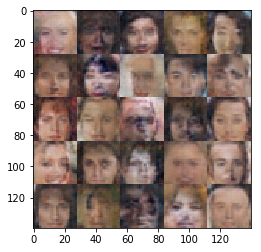

Epoch 1/1... Discriminator Loss: 1.6627 Generator Loss: 0.2726
Epoch 1/1... Discriminator Loss: 1.5188 Generator Loss: 0.3925
Epoch 1/1... Discriminator Loss: 1.1728 Generator Loss: 1.2117
Epoch 1/1... Discriminator Loss: 1.2816 Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 1.1970 Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.2324 Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.4305 Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: 1.3273 Generator Loss: 0.4638
Epoch 1/1... Discriminator Loss: 0.9828 Generator Loss: 1.2722
Epoch 1/1... Discriminator Loss: 1.2058 Generator Loss: 0.5387


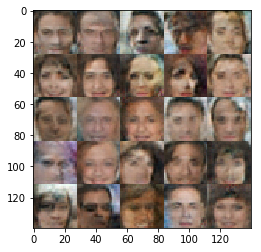

Epoch 1/1... Discriminator Loss: 0.9628 Generator Loss: 1.2962
Epoch 1/1... Discriminator Loss: 1.1781 Generator Loss: 0.5787
Epoch 1/1... Discriminator Loss: 1.3724 Generator Loss: 0.4954
Epoch 1/1... Discriminator Loss: 1.1842 Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.3422 Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.2418 Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.2946 Generator Loss: 1.5181
Epoch 1/1... Discriminator Loss: 1.0738 Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.3506 Generator Loss: 0.5075
Epoch 1/1... Discriminator Loss: 1.1872 Generator Loss: 1.0076


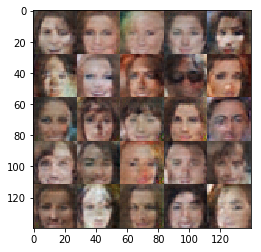

Epoch 1/1... Discriminator Loss: 1.2223 Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 0.9249 Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 1.2561 Generator Loss: 0.5316
Epoch 1/1... Discriminator Loss: 0.9401 Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.1497 Generator Loss: 1.1600
Epoch 1/1... Discriminator Loss: 0.9909 Generator Loss: 1.2243
Epoch 1/1... Discriminator Loss: 1.2664 Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.5744 Generator Loss: 1.5872
Epoch 1/1... Discriminator Loss: 1.1817 Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.0745 Generator Loss: 0.6880


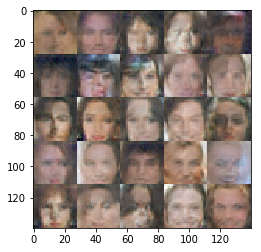

Epoch 1/1... Discriminator Loss: 1.4143 Generator Loss: 0.4265
Epoch 1/1... Discriminator Loss: 1.2483 Generator Loss: 0.5346
Epoch 1/1... Discriminator Loss: 1.2153 Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.2868 Generator Loss: 1.0160
Epoch 1/1... Discriminator Loss: 1.3827 Generator Loss: 0.4169
Epoch 1/1... Discriminator Loss: 1.1370 Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 1.2472 Generator Loss: 1.6075
Epoch 1/1... Discriminator Loss: 0.9591 Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 0.9663 Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.0259 Generator Loss: 1.0878


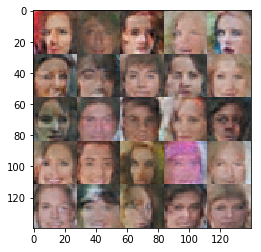

Epoch 1/1... Discriminator Loss: 1.2778 Generator Loss: 0.4559
Epoch 1/1... Discriminator Loss: 1.1203 Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 0.9581 Generator Loss: 1.8137
Epoch 1/1... Discriminator Loss: 1.1507 Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.1673 Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.0436 Generator Loss: 1.0664
Epoch 1/1... Discriminator Loss: 1.4627 Generator Loss: 0.3388
Epoch 1/1... Discriminator Loss: 1.3663 Generator Loss: 0.4900
Epoch 1/1... Discriminator Loss: 1.0913 Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.1321 Generator Loss: 0.6291


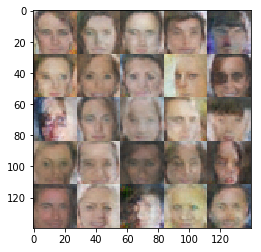

Epoch 1/1... Discriminator Loss: 1.3280 Generator Loss: 0.4912
Epoch 1/1... Discriminator Loss: 1.1310 Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.3497 Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.1972 Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.3557 Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 1.3049 Generator Loss: 0.4756
Final Output


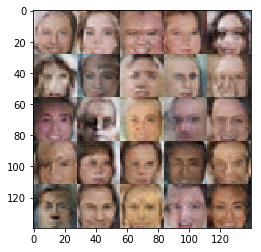

In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.